In [1]:
# === SET-UP =============================================================== #
import numpy as np
import pandas as pd
import os
from pathlib import Path
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit

# --- percorsi (adatta se servono) ----------------------------------------- #
FEATURE_DIR = Path("audio_features")    # .npz con "embeddings"
LABEL_DIR   = Path("labels")            # .npz con frame-label
META_CSV    = Path("metadata.csv")      # must contain 'filename'

# --- categorie (come da task) -------------------------------------------- #
CATEGORIES = [
    'Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus',
    'Car', 'Cat Meow', 'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell',
    'Crying', 'Dog Bark', 'Doorbell', 'Drip', 'Drums', 'Fire', 'Footsteps',
    'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
    'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle',
    'Piano', 'Pig Oink', 'Power Drill', 'Power Saw', 'Rain', 'Rooster Crow',
    'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat', 'Shout',
    'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River',
    'Thunder', 'Train', 'Truck', 'Trumpet', 'Vacuum Cleaner', 'Violin',
    'Washing Machine', 'Waves', 'Wind'
]
N_CAT = len(CATEGORIES)


In [2]:
# === FUNZIONI AUSILIARIE ================================================== #
def aggregate_labels(frame_labels):
    """
    Converte le liste di label-per-frame dei diversi annotatori in 0/1 singolo.
    """
    _out = []
    for fl in frame_labels:
        if sum(fl) == 0:                # tutti dicono 'assenza'
            _out.append(0)
        elif np.count_nonzero(fl) == len(fl):  # tutti dicono 'presenza'
            _out.append(1)
        else:                           # disaccordo -> scelta casuale
            _out.append(np.random.choice(fl))
    return _out

def load_frames(file_id):
    """
    Ritorna (X_frames, Y_frames) per un singolo file .wav.
    X_frames shape = (#frame, d_feat)
    Y_frames shape = (#frame, N_CAT)
    """
    feat = np.load(FEATURE_DIR / f"{file_id}.npz")["embeddings"]    # <-- qui potremo cambiare key
    labels_npz = np.load(LABEL_DIR / f"{file_id}_labels.npz")
    y_frames = np.column_stack([
        np.array(aggregate_labels(labels_npz[c]))  if c in labels_npz else
        np.zeros(feat.shape[0], dtype=int)
        for c in CATEGORIES
    ])
    return feat, y_frames

# === RACCOLTA DI TUTTI I FRAME, CON GRUPPI=ID FILE ======================= #
meta = pd.read_csv(META_CSV)
file_ids = meta["filename"].str.replace(".mp3", "")

X_list, Y_list, groups = [], [], []          # groups = id-file per GroupSplit

for fid in file_ids:
    fp = FEATURE_DIR / f"{fid}.npz"
    lp = LABEL_DIR   / f"{fid}_labels.npz"
    if not fp.exists() or not lp.exists():
        continue

    x_f, y_f = load_frames(fid)
    X_list.append(x_f)
    Y_list.append(y_f)
    groups.extend([fid] * len(x_f))          # un gruppo per frame == id file

# -- empilamento finale
X = np.concatenate(X_list, axis=0)
Y = np.concatenate(Y_list, axis=0)
groups = np.array(groups)

print("Shape X (tutti i frame, d):", X.shape)
print("Shape Y (tutti i frame, n_cat):", Y.shape)
print("Frame per primo file:", X_list[0].shape[0])
print("Dimensionalità feature (d):", X.shape[1])


Shape X (tutti i frame, d): (1538577, 768)
Shape Y (tutti i frame, n_cat): (1538577, 58)
Frame per primo file: 184
Dimensionalità feature (d): 768


In [3]:
# === SPLIT PER GROUP, 60% train – 20% val – 20% test ===================== #
gss = GroupShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, temp_idx = next(gss.split(X, Y, groups))

gss_val = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(gss_val.split(X[temp_idx], Y[temp_idx], groups[temp_idx]))

X_train, Y_train = X[train_idx], Y[train_idx]
X_val,   Y_val   = X[val_idx],   Y[val_idx]
X_test,  Y_test  = X[test_idx],  Y[test_idx]

print("\n#FILE unici in train:", len(np.unique(groups[train_idx])))
print("#FILE unici in val:  ", len(np.unique(groups[val_idx])))
print("#FILE unici in test: ", len(np.unique(groups[test_idx])))
print("Distribuzione label (train) — counts di 1 per classe:\n",
      Y_train.sum(axis=0)[:10], "...")  # prime 10 classi per brevità



#FILE unici in train: 4938
#FILE unici in val:   2432
#FILE unici in test:  2434
Distribuzione label (train) — counts di 1 per classe:
 [25571.  9486. 13619. 32421.  7475. 73824. 17878. 58966.  4587.  6534.] ...


In [ ]:
# === VARIANZA PER FEATURE ------------------------------------------------- #
vt = VarianceThreshold(threshold=1e-6)
vt.fit(X_train)
keep_mask = vt.get_support()

print(f"\n[VAR] Feature con varianza > 1e-6: {keep_mask.sum()} / {X.shape[1]}")

# --- mutua informazione (frame vs. "almeno una etichetta"):
y_any_event = (Y_train.sum(axis=1) > 0).astype(int)
mi = mutual_info_classif(X_train, y_any_event, discrete_features=False, random_state=42)

# Ordina per importanza MI
mi_sorted_idx = np.argsort(mi)[::-1]
topK = 50
top_features = mi_sorted_idx[:topK]

print(f"[MI] Top-{topK} feature idx per Mutual Information:", top_features[:10], "...")
print("[MI] Valori MI (prime 10):", mi[top_features[:10]])



[VAR] Feature con varianza > 1e-6: 768 / 768


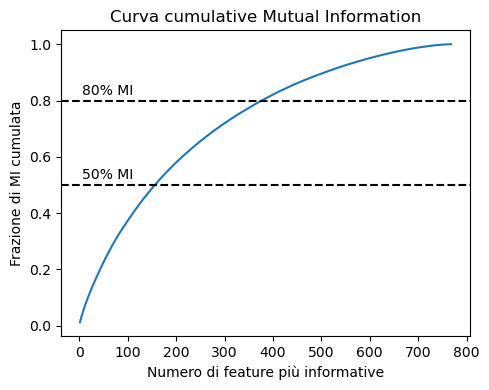

Top  32: MI cumulata = 0.160
Top  64: MI cumulata = 0.273
Top 128: MI cumulata = 0.441
Top 256: MI cumulata = 0.664
Top 384: MI cumulata = 0.807


In [ ]:
# ---- distribuzione MI ---------------------------------------------------- #
import matplotlib.pyplot as plt
mi_sorted = np.sort(mi)[::-1]          # già calcolata prima
cum_mi = np.cumsum(mi_sorted)

plt.figure(figsize=(5,4))
plt.plot(range(1, len(mi_sorted)+1), cum_mi / cum_mi[-1])
plt.axhline(0.5, ls='--', c='k'); plt.text(5, .52, '50% MI')
plt.axhline(0.8, ls='--', c='k'); plt.text(5, .82, '80% MI')
plt.xlabel('Number of most informative features')
plt.ylabel('Fraction of cumulated MI')
plt.title('Curve cumulative Mutual Information')
plt.tight_layout()
plt.show()

# ---- stampa “ginocchio” grezzo ------------------------------------------- #
for thr in [32, 64, 128, 256, 384]:
    print(f"Top {thr:>3}: MI cumulata = {cum_mi[thr-1]/cum_mi[-1]:.3f}")


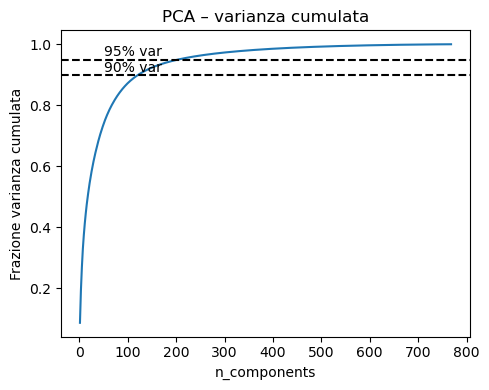

Prime  64 PC → var cumulata: 0.792
Prime 128 PC → var cumulata: 0.906
Prime 256 PC → var cumulata: 0.965
Prime 384 PC → var cumulata: 0.984


In [ ]:
# ---- PCA solo per analisi (no fit sul test!) ----------------------------- #
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

pca = PCA().fit(X_train_std)       # tutte le componenti

var_cum = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(5,4))
plt.plot(range(1, len(var_cum)+1), var_cum)
plt.axhline(0.9, ls='--', c='k'); plt.text(50, .91, '90% var')
plt.axhline(0.95, ls='--', c='k'); plt.text(50, .96, '95% var')
plt.xlabel('n_components')
plt.ylabel('Fraction of cumulated var')
plt.title('PCA – Cumulated Var')
plt.tight_layout()
plt.show()

# qualche stampa tattica
for thr in [64, 128, 256, 384]:
    print(f"Prime {thr:>3} PC → var cumulata: {var_cum[thr-1]:.3f}")


In [4]:
from sklearn.utils import resample

MI_K      = 256     # feature selezionate via Mutual Information
PCA_COMP  = 128     # componenti PCA
N_SUB     = 200_000 # sotto-campione per velocizzare il prototipo

X_sub, Y_sub = resample(
    X_train, Y_train,
    n_samples=N_SUB,
    random_state=42,
    stratify=(Y_train.sum(axis=1) > 0)    # bilancia “eventi” vs “non-eventi”
)

In [5]:
# --- 1) target binario per la MI ----------------------------------------- #
y_any_sub = (Y_sub.sum(axis=1) > 0).astype(int)   # 1 se almeno una label

# --- 2) calcola maschera top-K feature ----------------------------------- #
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

sc_tmp = StandardScaler()                 # scaler temporaneo
X_sub_std = sc_tmp.fit_transform(X_sub)   # serve dati standardizzati

sel = SelectKBest(mutual_info_classif, k=MI_K)
sel.fit(X_sub_std, y_any_sub)             # **y = 1-D**
mask_mi = sel.get_support()

print(f"[MI{MI_K}] feature selezionate:", mask_mi.sum())

# --- 3) trasforma *tutti* i set con la stessa selezione ------------------ #
def apply_mask(X, scaler, mask):
    X_std = scaler.transform(X)
    return X_std[:, mask]

X_train_mi = apply_mask(X_train, sc_tmp, mask_mi)
X_val_mi   = apply_mask(X_val,   sc_tmp, mask_mi)


[MI256] feature selezionate: 256


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score
import time

clf_mi = MultiOutputClassifier(LogisticRegression(max_iter=1000))

t0 = time.time();  clf_mi.fit(X_train_mi, Y_train)
print(f"[MI{MI_K}] Fit in {(time.time()-t0)/60:.1f} min")

def macro_bacc(model, Xv, Yv):
    Yp = model.predict(Xv)
    return np.mean([balanced_accuracy_score(Yv[:,i], Yp[:,i])
                    for i in range(Yv.shape[1])])

print("   Macro-BAcc (val):", macro_bacc(clf_mi, X_val_mi, Y_val))


[MI256] Fit in 7.2 min


/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


   Macro-BAcc (val): 0.7226434846148493


/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [11]:
from sklearn.pipeline import Pipeline
pipe_pca = Pipeline([
    ('sc',  StandardScaler()),
    ('pca', PCA(n_components=PCA_COMP, random_state=42)),
    ('clf', MultiOutputClassifier(LogisticRegression(max_iter=1000)))
])
pipe_pca.fit(X_sub, Y_sub)
print("   Macro-BAcc (val):", macro_bacc(pipe_pca, X_val, Y_val))


/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


   Macro-BAcc (val): 0.6953799058330683


/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [12]:
pipe_full = Pipeline([
    ('sc', StandardScaler()),
    ('clf', MultiOutputClassifier(LogisticRegression(max_iter=1000)))
])

pipe_full.fit(X_sub, Y_sub)   # X_sub, Y_sub già campionati
print("Full-768 → Macro-BAcc (val):", macro_bacc(pipe_full, X_val, Y_val))



/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Full-768 → Macro-BAcc (val): 0.7757313214631807


/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [ ]:
# 'from sklearn.feature_selection import SelectFromModel
# # --- param grid ---------------------------------------------------------- #
# MI_K_LIST     = [256, 384, 512]
# PCA_COMP_LIST = [128, 256]
# CLF_LIST = [
#     ("logreg_C1" , LogisticRegression(max_iter=1000, C=1.0)),
#     ("logreg_C01", LogisticRegression(max_iter=1000, C=0.1)),
# ]

# results = []

# # --- funzione valutazione ------------------------------------------------ #
# def macro_bacc(model, Xv, Yv):
#     Yp = model.predict(Xv)
#     return np.mean([balanced_accuracy_score(Yv[:,i], Yp[:,i])
#                     for i in range(Yv.shape[1])])

# # --- loop MI ------------------------------------------------------------- #
# for K in MI_K_LIST:
#     y_any_sub = (Y_sub.sum(axis=1) > 0).astype(int)
#     sel = SelectKBest(mutual_info_classif, k=K).fit(X_sub_std, y_any_sub)
#     mask = sel.get_support()
#     X_tr_mi = apply_mask(X_train, sc_tmp, mask)
#     X_val_mi = apply_mask(X_val,   sc_tmp, mask)
#     for name, base_clf in CLF_LIST:
#         clf = MultiOutputClassifier(base_clf)
#         clf.fit(X_tr_mi, Y_train)
#         score = macro_bacc(clf, X_val_mi, Y_val)
#         results.append(("MI", K, name, score))

# # --- loop PCA ------------------------------------------------------------ #
# for N in PCA_COMP_LIST:
#     pipe = Pipeline([
#         ('sc', StandardScaler()),
#         ('pca', PCA(n_components=N, random_state=42)),
#         ('clf', MultiOutputClassifier(LogisticRegression(max_iter=1000)))])
#     pipe.fit(X_sub, Y_sub)
#     score = macro_bacc(pipe, X_val, Y_val)
#     results.append(("PCA", N, "logreg", score))

# # --- RF-SelectFromModel --------------------------------------------------- #
# for thr in ["median", 0.75]:
#     sel_rf = SelectFromModel(
#     RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
#         threshold=-np.inf,          # disattiva la soglia assoluta
#         max_features=256            # << scegli tu 256, 384, 512…
#     )

#     mask = sel_rf.get_support()
#     X_tr_rf = apply_mask(X_train, sc_tmp, mask)
#     X_val_rf = apply_mask(X_val,   sc_tmp, mask)
#     n_keep = mask.sum()
#     clf = MultiOutputClassifier(LogisticRegression(max_iter=1000))
#     clf.fit(X_tr_rf, Y_train)
#     score = macro_bacc(clf, X_val_rf, Y_val)
#     results.append(("RFsel", n_keep, "logreg", score))

# # --- stampa tabellina ---------------------------------------------------- #
# for r in sorted(results, key=lambda x: -x[3]):
#     print(f"{r[0]:5} {r[1]:>4} {r[2]:12}  →  Macro-BAcc = {r[3]:.3f}")
# '

/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/ho

ValueError: Found array with 0 feature(s) (shape=(922954, 0)) while a minimum of 1 is required by LogisticRegression.

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score
import time

# 1) calcola importanze su sotto-campione già standardizzato
sel_rf = SelectFromModel(
    RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    threshold=-np.inf,      # disabilita soglia
    max_features=384        # <-- scegli 256/384/512
)
sel_rf.fit(X_sub_std, y_any_sub)

mask = sel_rf.get_support()
print("Feature tenute:", mask.sum())      # dovresti vedere es. 384

# 2) trasforma train/val
X_train_rf = apply_mask(X_train, sc_tmp, mask)
X_val_rf   = apply_mask(X_val,   sc_tmp, mask)

# 3) quick model
clf_rf = MultiOutputClassifier(LogisticRegression(max_iter=1000))
clf_rf.fit(X_train_rf, Y_train)

def macro_bacc(model, Xv, Yv):
    Yp = model.predict(Xv)
    return np.mean([balanced_accuracy_score(Yv[:,i], Yp[:,i])
                    for i in range(Yv.shape[1])])
print("Macro-BAcc (val):", macro_bacc(clf_rf, X_val_rf, Y_val))

Feature tenute: 384


NameError: name 'macro_bacc' is not defined

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

final_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MultiOutputClassifier(
        LogisticRegression(max_iter=1000, C=1.0, penalty='l2')  # C scelto dopo test
    ))
])
final_pipe.fit(X_train, Y_train)

print("Macro-Balanced Accuracy (val):",
      macro_bacc(final_pipe, X_val, Y_val))   # ≈ 0.776


KeyboardInterrupt: 